# Model fitting exercise

We work with the Ricker equation. Recall that

$$
\hat{N}_{t+1} = N_t e^{r_0 \left( 1 - \frac{N_t}{K} \right)}
$$

Which predicts population size at $t+1$ given population at time $t$, intrinsic growth rate $r_0$, and carrying capacity $K$.

In [13]:
# Load libraries and data
library(here)
Ringlets <- read.csv(here("Exercises", "Model_Fitting", "Ringlets.csv"))

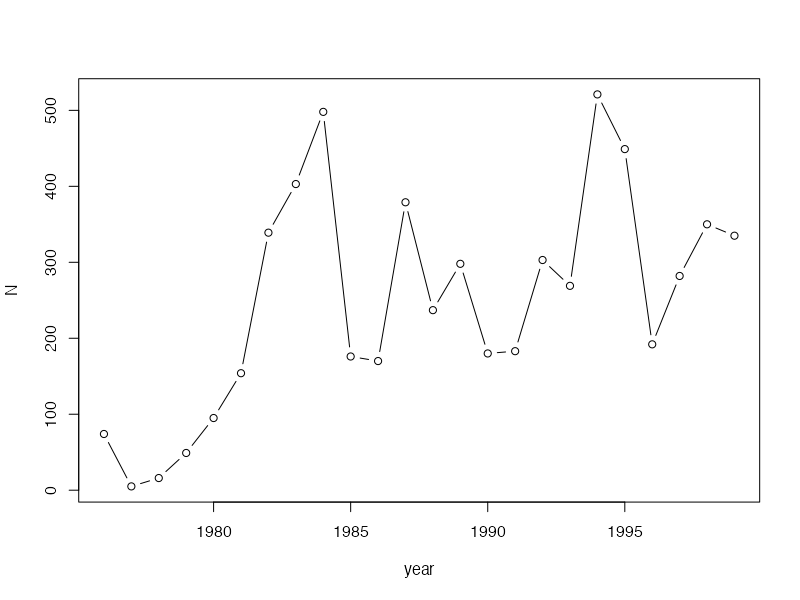

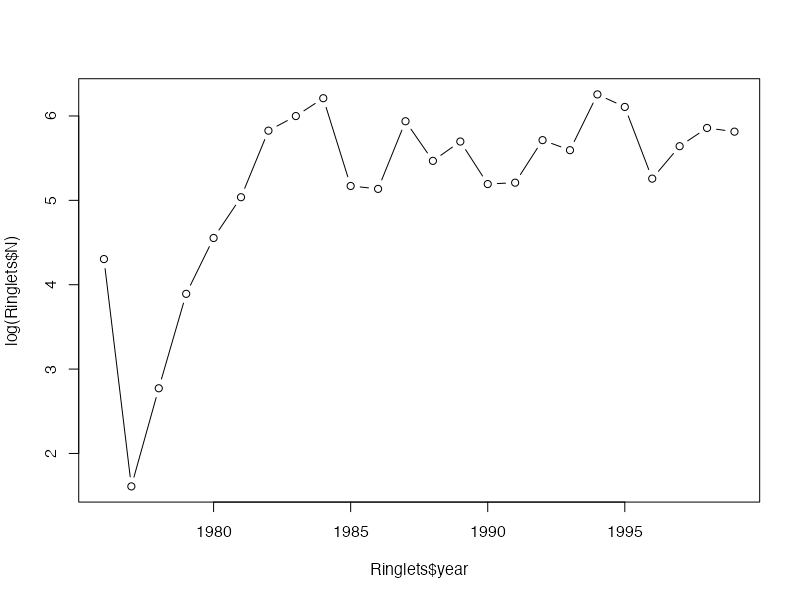

In [14]:
plot(Ringlets, type = "b")  # Plot raw data
plot(Ringlets$year, log(Ringlets$N), type = "b")  # Plot log data

Goal: fit a model, use the model to predict the future of the population.

The Ricker model predicts population size at time $t+1$ given population at time $t$. In other words, we use $N_1 : N_{23}$ to predict $N_2 : N_{24}$.

$$
\hat{N}_{t+1} = N_t e^{r_0 \left( 1 - \frac{N_t}{K} \right)}
$$

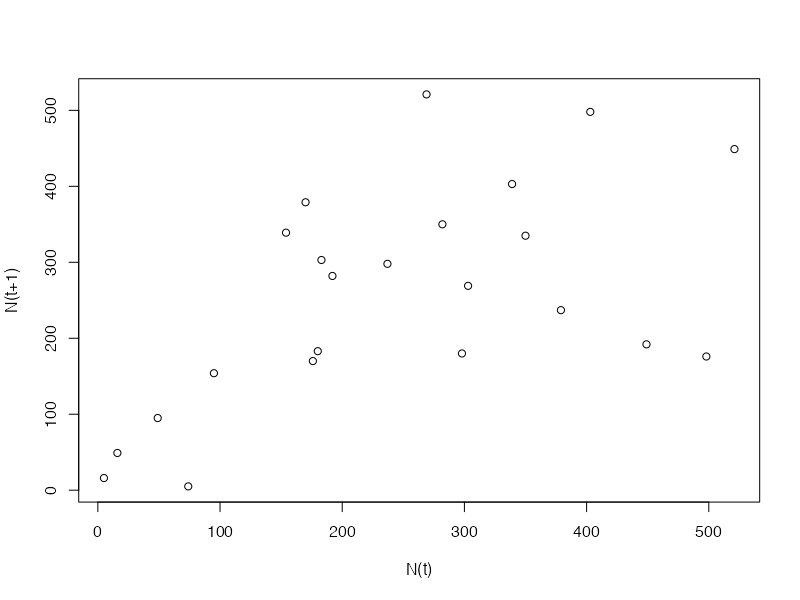

In [15]:
# Create two vectors with corresponding population sizes
Nt <- Ringlets$N[1:23]
Ntplus1 <- Ringlets$N[2:24]
plot(Nt, Ntplus1, xlab = "N(t)", ylab = "N(t+1)")  # Plot

It's hard to say if the above plot looks like a Ricker function.

Below, we use `nls` (non-linear least squares function) to estimate $r_0$ and $K$ parameters.

In [16]:
Rickerfit <- nls(
  Ntplus1 ~ Nt*exp(r0 * (1 - Nt / K)),
  data = list(Nt = Nt),
  start = list(r0 = 1, K = 100)
)
summary(Rickerfit)


Formula: Ntplus1 ~ Nt * exp(r0 * (1 - Nt/K))

Parameters:
   Estimate Std. Error t value Pr(>|t|)
r0   0.8913     0.2212   4.029 0.000606
K  329.3594    29.7616  11.067 3.19e-10
      
r0 ***
K  ***
---
Signif. codes:  
  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’
  0.1 ‘ ’ 1

Residual standard error: 103.9 on 21 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 1.72e-06


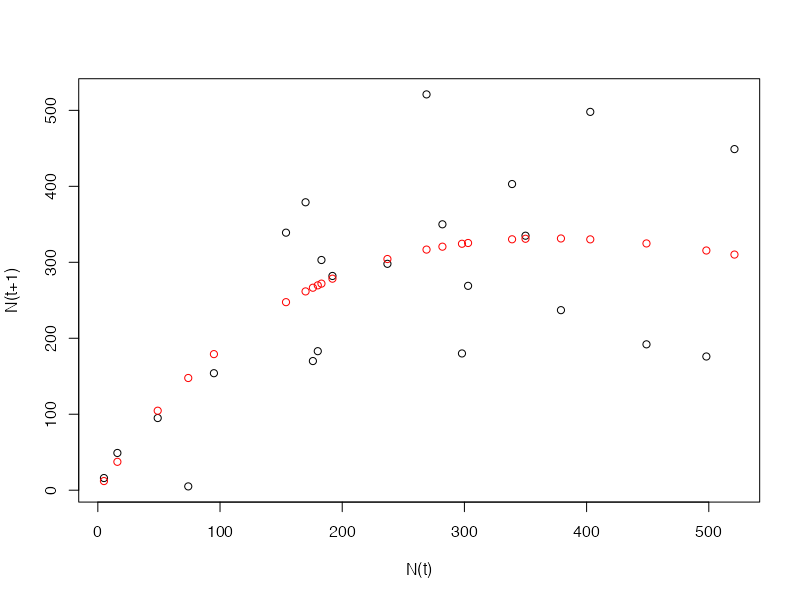

In [17]:
# Add predicted values to the previous plot
plot(Nt, Ntplus1, xlab = "N(t)", ylab = "N(t+1)")
points(Nt, fitted(Rickerfit), col = "red")

Above, see that a Ricker function was fitted to the data.

Below, see that the magnitude of the residuals seems to increase with population $\left( N_t \right)$.

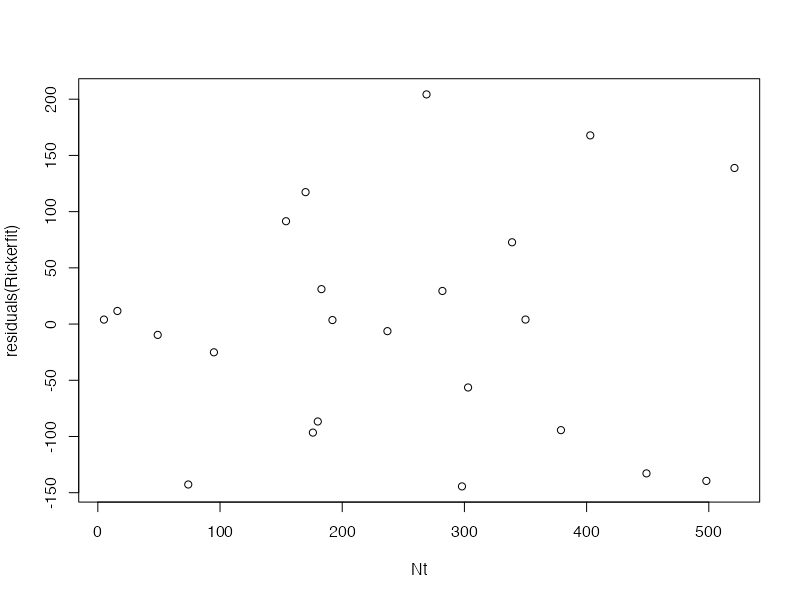

In [18]:
plot(Nt, residuals(Rickerfit))

Instead of the trend above, where the parameter fit was carried out by minimizing the residuals in terms of **predicted population size**, we want to model per capita growth rate.

Below, we calculate the log population growth rate, defined as

$$
r_t = ln \left( \frac{N_{t+1}}{N_t} \right)
$$

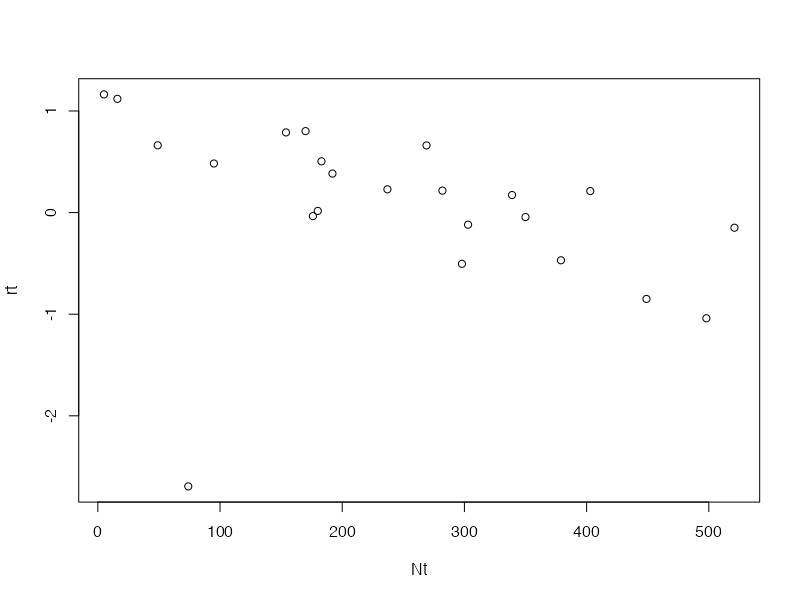

In [19]:
rt <- log(Ntplus1 / Nt)
plot(Nt, rt)

The ricker equation states that this should be a linear relationship.

$$
ln \left( \frac{N_{t+1}}{N_t} \right)
= r_0 \left( 1 - \frac{N_t}{K} \right)
$$

Notice the point `rt[1]`. This represents a severe drought. A model will struggle to predict this event.

Below: the above exercises were repeated without the datapoint from the drought.

In [115]:
# Recalculate values
Ringlets_outDrop <- Ringlets[-1,]  # Drop 1976
Nt_o <- Ringlets_outDrop$N[1:22]
Ntplus1_o <- Ringlets_outDrop$N[2:23]
rt_o <- log(Ntplus1_o / Nt_o)

# Refit model, this time with the log population growth rate rt_o
rt_fit <- nls(
  rt_o ~ r0 * (1 - Nt_o / K),
  data = list(Nt_o = Nt_o),
  start = list(r0 = 1, K = 100)
)
summary(rt_fit)


Formula: rt_o ~ r0 * (1 - Nt_o/K)

Parameters:
   Estimate Std. Error t value Pr(>|t|)
r0   1.0038     0.1486   6.753 1.44e-06
K  311.4885    24.6677  12.627 5.50e-11
      
r0 ***
K  ***
---
Signif. codes:  
  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’
  0.1 ‘ ’ 1

Residual standard error: 0.3445 on 20 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 2.973e-09


To use this model in something like a Monte Carlo simulation, we need to include environmental fluctuations.

$$
N_{t+1}
= N_t e^{r_o \left( 1 - \frac{N_t}{K} \right)
+ \epsilon_t}
$$

We still dont have $\sigma$ in the model, but since $\epsilon$ in the model corresponds to the residual in the last model fit, we use the SE as a direct estimate of $\sigma$. We can get the predicted standard deviation from the model by checking the `Residual standard error` in the summary above. Thus

$$
\hat{\sigma} = 0.3445
$$

Below: check if $\hat{\sigma} \approx \sqrt{\frac{RSS}{n-k}}$

Where $RSS$ is sum of squared residuals, $n$ is the number of data points, and $k$ is the number of parameters in the linear model(in this case, intrinsic growth rate $r_0$ and carrying capacity $K$).

In [187]:
sqrt(sum(residuals(rt_fit)^2)/(length(rt)-2))

[1] 0.3362391

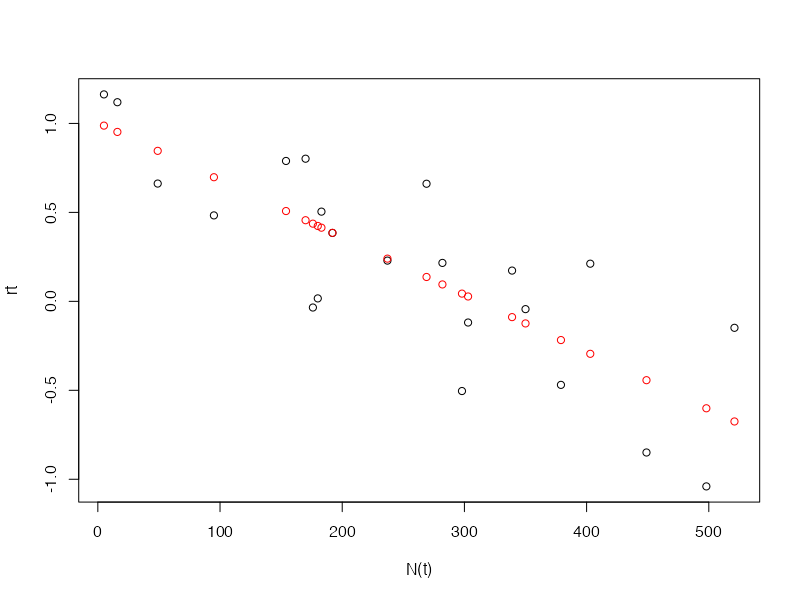

In [144]:
# Show prediction vs real value for exponential model
plot(Nt_o, rt_o, xlab = "N(t)", ylab = "rt")
points(Nt_o, fitted(rt_fit), col = "red")

Above: remember, $r_t$ represents exponential growth. Since $r_t = r_0 \left(1 - \frac{N_t}{K} \right)$, if $r_t = 0$ the entire Ricker equation evaluates to

$$
N_{t+1} = N_t e^{r_0 \left(1 - \frac{N_t}{K} \right)}
= N_t e^0 \\
\downarrow \\
N_{t+1} = N_t
$$

Thus, $r_t = 0$ represents an equilibrium.

## Model selection

Below, we try different models. The Hassel model is defined as

$$
N_{t+1} = \frac{\lambda N_t}{\left( 1 + aN_t \right)^b}
$$

and has 3 parameters: $\lambda$, $a$, and $b$.

Where the exponential growth rate of the model is defined as

$$
r_t = ln \left( \frac{N_{t+1}}{N_t} \right)
$$

Recall

$$
N_{t+1} = N_t e^{r_0 \left( 1 - \frac{N_t}{K} \right)} \\
\downarrow \\
\frac{N_{t+1}}{N_t} = e^{r_0 \left( 1 - \frac{N_t}{K} \right)} \\
\downarrow \\
ln \left( \frac{N_{t+1}}{N_t} \right) = r_0 \left( 1 - \frac{N_t}{K} \right) = r_t
$$

Subbing in our new definition of $N_{t+1}$, we get

$$
r_t = ln \left( \frac{
    \frac{\lambda N_t}{\left( 1 + aN_t \right)^b}
}{N_t} \right) \\
\downarrow \\
r_t = ln \left(\frac{\lambda N_t}{N_t \left( 1 + aN_t \right)^b} \right) \\
\downarrow \\
r_t = ln \left(\frac{\lambda}{\left( 1 + aN_t \right)^b} \right) \\
$$

In [118]:
# Fit Hassel model
rt_o <- log(Ntplus1_o / Nt_o)  # Redefine log change in response for every time step

# Refit model, with the log population growth rate rt_o
rt_fit_hassel <- nls(
  rt_o ~ log(lambda / (1 + a * Nt_o)^b),
  data = list(Nt_o = Nt_o),
  start = list(lambda = 1.1, a = 0.001, b = 1)
)
summary(rt_fit_hassel)


Formula: rt_o ~ log(lambda/(1 + a * Nt_o)^b)

Parameters:
        Estimate Std. Error t value
lambda  2.896325   0.664456   4.359
a       0.000924   0.003043   0.304
b       4.283457  11.646237   0.368
       Pr(>|t|)    
lambda 0.000338 ***
a      0.764695    
b      0.717090    
---
Signif. codes:  
  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’
  0.1 ‘ ’ 1

Residual standard error: 0.3524 on 19 degrees of freedom

Number of iterations to convergence: 4 
Achieved convergence tolerance: 7.87e-06


Notice that the $AIC$ is lower for the Ricker function fit than the Hassel function. The Hassel model was penalized for having more params.

In [134]:
rt_fit_hassel$m$getPars()

      lambda            a            b 
2.8963246942 0.0009239659 4.2834568142 

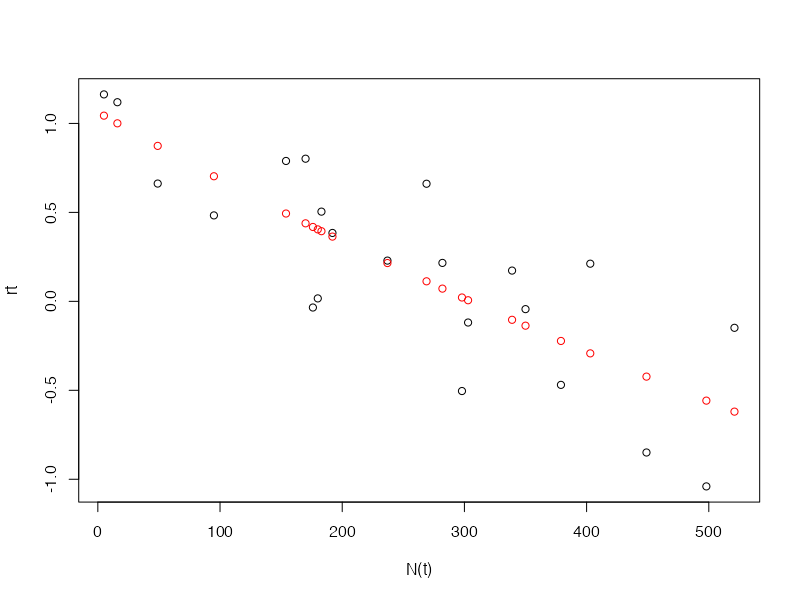

In [147]:
# Show prediction vs real value for exponential model
plot(Nt_o, rt_o, xlab = "N(t)", ylab = "rt")
points(Nt_o, fitted(rt_fit_hassel), col = "red")

In [119]:
print(AIC(rt_fit))
print(AIC(rt_fit_hassel))

[1] 19.45281
[1] 21.31359


## Monte Carlo simulation

1. Write an R-script that uses the parameter values from a given model and simulates Ringlet dynamics 100 years into the future using the last known population size as a starting value, plotting the result.

2. Run 1000 realizations of that 100 year simulation. Plot the 20 first realizations in one plot

3. Simulate extinction risk by finding the % of realizations that ended in extinction, defined by $N<2$.

4. Change parameter values, check if extinction risk becomes more substantial

5. Try to plot extinction risk as a function of one or more of the parameter values

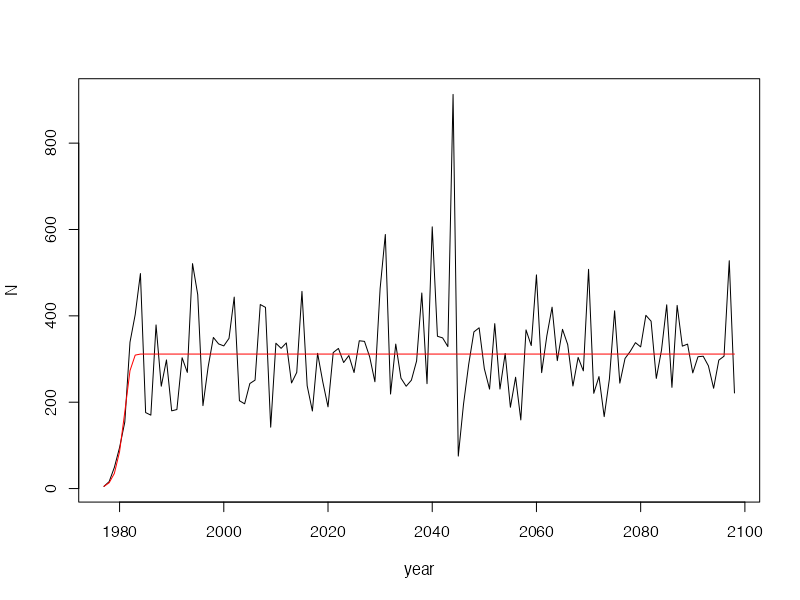

In [300]:
## 1. N-year simulation
n_yr_sim <- function(n_yr = 100, deterministic = F, init_data, params, pred_sd, return_extinct = F) {
  if (deterministic) {
    model <- function(params, pop, pred_sd) {  # Define model function
      return(pop * exp(params[1] * (1 - pop / params[2])))
    }    
  } else {
    model <- function(params, pop, pred_sd) {  # Define model function
      return(pop * exp(params[1] * (1 - pop / params[2]) + rnorm(1, mean = 0, sd = pred_sd)))
    }
  }
  yrs <- seq(init_data$year, init_data$year + n_yr - 1)  # Create vector of years
  annual_pop <- rep(init_data$N, n_yr)  # Initialize vector to store annual population counts in
  for (i in 1:(n_yr-1)) {  # Loop through range of years
    pop <- annual_pop[i]  # Define current population
    annual_pop[i+1] <- model(params, pop, pred_sd)
    if (return_extinct & annual_pop[i+1] < 2) {
      return(T)
    }
  }
  if (return_extinct) {
    return(F)
  } else {
    df <- data.frame(cbind(yrs[-1], annual_pop[-1]))  # Create dataframe, drop "seed" year
    names(df) <- c("year", "N")  # Name columns
    return(df)  # Return population counts
  }
}

init_data <- Ringlets_outDrop[length(Ringlets_outDrop$N),]  # Get initial data
params <- rt_fit$m$getPars()  # Initialize parameters
pred_sd <- sqrt(sum(residuals(rt_fit)^2)/(length(rt)-2))  # Get residual standard error from model

Ringlets_future <- n_yr_sim(100, F, init_data, params, pred_sd)  # Generate future data
Ringlets_past_future <- rbind(Ringlets_outDrop, Ringlets_future)  # Combine original and future data into one dataframe
plot(Ringlets_past_future, type = "l")  # Plot

init_data_determ <- Ringlets_outDrop[1,]  # Get initial data for deterministic model

Ringlets_deterministic <- n_yr_sim(100+length(Ringlets_outDrop$year)-1, T, init_data_determ, params)  # Generate deterministic data
Ringlets_deterministic <- rbind(init_data_determ, Ringlets_deterministic)  # Add first unsimulated row
points(Ringlets_deterministic, type = "l", col = "red")  # Plot

In [294]:
a = 2
c = 3
if (a > 1 & c < 1) print("true")

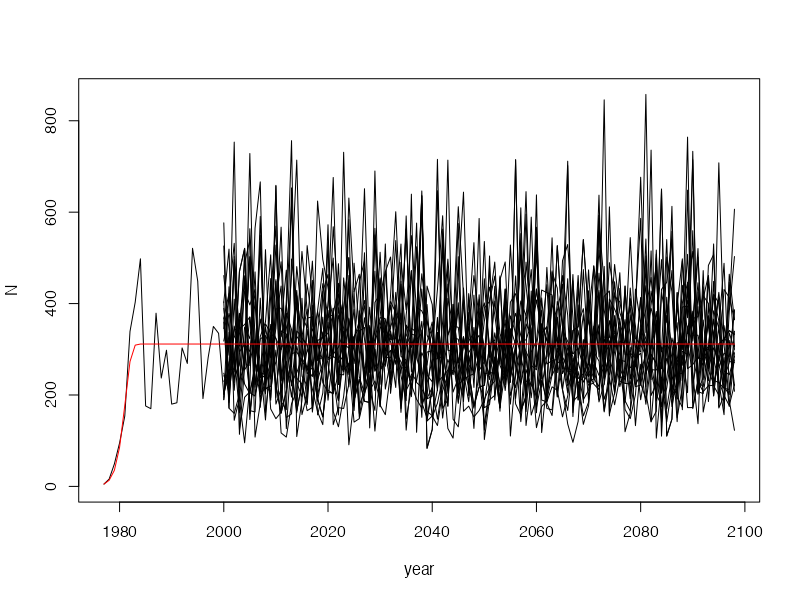

In [298]:
## Plot 20 realizations
set.seed(30)
Ringlets_future <- n_yr_sim(100, F, init_data, params, pred_sd)  # Generate future data
Ringlets_past_future <- rbind(Ringlets_outDrop, Ringlets_future)  # Combine original and future data into one dataframe

n_realizations <- 20
min <- 0
max <- Ringlets_deterministic[100,2]

# Get axis limits
for (i in 2:(n_realizations)) {
  Ringlets_future <- n_yr_sim(100, F, init_data, params, pred_sd)  # Generate future data
  if (min(Ringlets_future$N) < min) min <- min(Ringlets_future$N)
  if (max(Ringlets_future$N) > max) max <- max(Ringlets_future$N)
}

# Plot
set.seed(30)
plot(Ringlets_past_future, type = "l", ylim = c(min, max))
for (i in 2:(n_realizations)) {
  Ringlets_future <- n_yr_sim(100, F, init_data, params, pred_sd)  # Generate future data
  points(Ringlets_future, type = "l")
}
points(Ringlets_deterministic, type = "l", col = "red")  # Plot

In [327]:
## 3. Get extinction risk
n_realizations <- 1000
extinct <- 0

# params <- rt_fit$m$getPars()  # Initialize parameters
params <- c(0, 1000)  # Try other params

for (i in 1:(n_realizations)) {
  extinct <- extinct + n_yr_sim(100, F, init_data, params, pred_sd, return_extinct = T)  # Update extinction rate
}

cat(paste0("Extinction risk: ", round(extinct / n_realizations * 100, 1), "%"))

Extinction risk: 12.5%

In [354]:
## 4. Plot extinction risk as a function of multiple parameter values

range <- 5

r0_range <- seq(0, 2, length.out = range)
K_range <- seq(50, 450, length.out = range)
n_realizations <- 1000
extinction_rates_df <- data.frame()
extinction_rates_m <- matrix(nrow = range, ncol = range, dimnames = list(r0_range, K_range))
rownames(extinction_rates_m) <- paste0("r0 = ", r0_range)
colnames(extinction_rates_m) <- paste0("K = ", K_range)

for (i in seq_along(r0_range)) {
  for (j in seq_along(K_range)) {
    extinct <- 0
    params <- c(r0_range[i], K_range[j])
    for (k in 1:(n_realizations)) {
      extinct <- (extinct + n_yr_sim(100, F, init_data, params, pred_sd, return_extinct = T))  # Update extinction rate
    }
    extinct_rate <- extinct / n_realizations
    row <- c(params, extinct_rate)
    extinction_rates_df <- rbind(extinction_rates_df, row)
    extinction_rates_m[i,j] <- extinct_rate
  }
}
names(extinction_rates_df) <- c("r0", "K", "Extinction_rate")
print(extinction_rates_m)
print(extinction_rates_df)

         K = 50 K = 150 K = 250 K = 350 K = 450
r0 = 0    0.119   0.109   0.107   0.098   0.103
r0 = 0.5  0.000   0.000   0.000   0.000   0.000
r0 = 1    0.956   0.000   0.000   0.000   0.000
r0 = 1.5  1.000   0.000   0.000   0.000   0.000
r0 = 2    1.000   0.026   0.011   0.005   0.011
    r0   K Extinction_rate
1  0.0  50           0.119
2  0.0 150           0.109
3  0.0 250           0.107
4  0.0 350           0.098
5  0.0 450           0.103
6  0.5  50           0.000
7  0.5 150           0.000
8  0.5 250           0.000
9  0.5 350           0.000
10 0.5 450           0.000
11 1.0  50           0.956
12 1.0 150           0.000
13 1.0 250           0.000
14 1.0 350           0.000
15 1.0 450           0.000
16 1.5  50           1.000
17 1.5 150           0.000
18 1.5 250           0.000
19 1.5 350           0.000
20 1.5 450           0.000
21 2.0  50           1.000
22 2.0 150           0.026
23 2.0 250           0.011
24 2.0 350           0.005
25 2.0 450           0.011


In [360]:
cat("Extinction rates as matrix:\n")
print(extinction_rates_m)
cat("\nExtinction rates as dataframe:\n")
print(extinction_rates_df)

Extinction rates as matrix:
         K = 50 K = 150 K = 250 K = 350 K = 450
r0 = 0    0.119   0.109   0.107   0.098   0.103
r0 = 0.5  0.000   0.000   0.000   0.000   0.000
r0 = 1    0.956   0.000   0.000   0.000   0.000
r0 = 1.5  1.000   0.000   0.000   0.000   0.000
r0 = 2    1.000   0.026   0.011   0.005   0.011

Extinction rates as dataframe:
    r0   K Extinction_rate
1  0.0  50           0.119
2  0.0 150           0.109
3  0.0 250           0.107
4  0.0 350           0.098
5  0.0 450           0.103
6  0.5  50           0.000
7  0.5 150           0.000
8  0.5 250           0.000
9  0.5 350           0.000
10 0.5 450           0.000
11 1.0  50           0.956
12 1.0 150           0.000
13 1.0 250           0.000
14 1.0 350           0.000
15 1.0 450           0.000
16 1.5  50           1.000
17 1.5 150           0.000
18 1.5 250           0.000
19 1.5 350           0.000
20 1.5 450           0.000
21 2.0  50           1.000
22 2.0 150           0.026
23 2.0 250           0.011
24 2

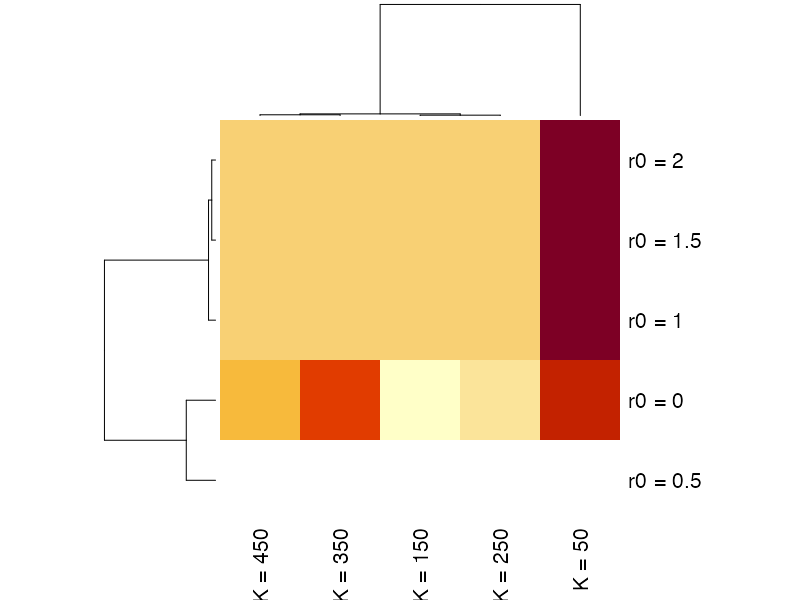

In [351]:
heatmap(extinction_rates_m)